In [ ]:
#!pip install nltk tensorflow

In [ ]:
#!pip install tensorflow numpy

In [ ]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalMaxPooling1D

from tensorflow.keras.models import load_model

from matplotlib.ticker import MultipleLocator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In this notebook, I will create two different HAN models to predict genre of songs. The performance of this model, as well as it's contribution to the ensemble model, will be compared against the Logistic Regression and BiDirectional Long-Short-Term-Memory (Bi-LSTM) models.

### 1) Loading in Trained Word2Vec Model and Creating Embeddings

More details for my specific creation of the csutom word2vec model and document/line embeddings can be found in the baselineLogisticRegression - Lyric Content notebook.

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

#### a. Process training data by splitting into train/validation split ('testing' blind data is from another file) and tokenizing

In [ ]:
han_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [ ]:
lyric_lists = [song.splitlines() for song in han_data['Lyrics']]
han_data['Lyrics as Lists'] = lyric_lists
han_data.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [ ]:
han_data['Lyrics as Lists'][24]

["I don't want to die",
 'Even though I have to',
 'I just want to live a long, long time',
 'And I see the gang to which I belong',
 'Time to sing out our happy song',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?",
 "I don't wanna grow",
 "Even if it's good growth",
 'I just wanna stay just like this',
 'And I see the comfortable place to rest',
 'Time to get this $^@! off my chest',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?."]

In [ ]:
# use the same split as for all of the models
train_han, val_han = train_test_split(han_data, test_size=0.2, random_state=24, stratify = han_data['Genre'])

In [ ]:
print(train_han['Genre'].value_counts())
print(val_han['Genre'].value_counts())

Metal         1200
Folk          1200
Country       1200
Hip-Hop       1200
Rock          1200
Jazz          1200
Electronic    1200
Pop           1200
Indie         1200
R&B           1200
Name: Genre, dtype: int64
Hip-Hop       300
Country       300
Pop           300
Folk          300
R&B           300
Jazz          300
Rock          300
Electronic    300
Indie         300
Metal         300
Name: Genre, dtype: int64


In [ ]:
train_lyrics = train_han['Lyrics as Lists']
val_lyrics = val_han['Lyrics as Lists']

In [ ]:
train_tokenized_lines = [word_tokenize(line.lower()) for lines_list in train_lyrics for line in lines_list]

#### b. apply the word2vec model to create line-level embeddings

In [ ]:
def lyrics_to_embeddings(lines, model):
    tokenized_lines = [word_tokenize(line.lower()) for line in lines]
    embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
    return embeddings

In [ ]:
train_han['Embeddings'] = train_han['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_han['Embeddings'] = val_han['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

### 2) Create HAN Model

#### a. Preprocessing of data into the right format (I already have a line level embeddings so I can skip the steps of creating that from word embeddings)

In [ ]:
train_han['Genre'] = train_han['Genre'].astype('category').cat.codes
val_han['Genre'] = val_han['Genre'].astype('category').cat.codes

# need to convert genre labels to one-hot encoding to use the keras library
y_train = tf.keras.utils.to_categorical(train_han['Genre'], num_classes=10)
y_val = tf.keras.utils.to_categorical(val_han['Genre'], num_classes=10)

In [ ]:
X_train = train_han['Embeddings']
X_val = val_han['Embeddings']

In [ ]:
X_train_padded = pad_sequences(X_train, maxlen=300, dtype='float32', padding='post', truncating='post', value=0.0)
X_val_padded = pad_sequences(X_val, maxlen=300, dtype='float32', padding='post', truncating='post', value=0.0)

In [ ]:
X_train_array = np.array(X_train_padded)
X_val_array = np.array(X_val_padded)

In [ ]:
print("X_train_array shape:", X_train_array.shape)
print("X_val_array shape:", X_val_array.shape)

X_train_array shape: (12000, 300, 100)
X_val_array shape: (3000, 300, 100)


#### b. Create the function to set up and compile the model

In [ ]:
def hierarchical_attention_network(max_sentence_length, embedding_dim, num_classes):
    # Input layer
    sentence_input = Input(shape=(max_sentence_length, embedding_dim), dtype='float32')

    # Sentence-level BiLSTM
    sentence_lstm = Bidirectional(LSTM(100, return_sequences=True))(sentence_input)

    # Attention mechanism at sentence level
    sentence_attention = tf.keras.layers.Attention()([sentence_lstm, sentence_lstm])
    sentence_representation = tf.keras.layers.Concatenate(axis=-1)([sentence_lstm, sentence_attention])

    # Fully connected layer
    global_pooling = GlobalMaxPooling1D()(sentence_representation)
    fc_layer = Dense(200, activation='relu')(global_pooling)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(fc_layer)

    # Model compilation
    model = tf.keras.models.Model(inputs=sentence_input, outputs=output_layer)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
max_sentence_length = 300
embedding_dim = 100
num_classes = 10

#### c. Run the model/train the model

In [ ]:
model_han = hierarchical_attention_network(max_sentence_length, embedding_dim, num_classes)
model_han.fit(X_train_array, y_train, epochs=3, batch_size=16, validation_split=0.2)

Epoch 1/3
600/600 [==============================] - 24s 33ms/step - loss: 2.0132 - accuracy: 0.2746 - val_loss: 1.8765 - val_accuracy: 0.3142
Epoch 2/3
600/600 [==============================] - 19s 32ms/step - loss: 1.7665 - accuracy: 0.3769 - val_loss: 1.8287 - val_accuracy: 0.3500
Epoch 3/3
600/600 [==============================] - 19s 31ms/step - loss: 1.6105 - accuracy: 0.4315 - val_loss: 1.7956 - val_accuracy: 0.3812


In [ ]:
y_pred = model_han.predict(X_val_array)

y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
accuracy

94/94 [==============================] - 2s 13ms/step


0.386

In [ ]:
model_han = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_han_content')

In [ ]:
y_pred = model_han.predict(X_val_array)

y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
accuracy

94/94 [==============================] - 7s 12ms/step


0.386

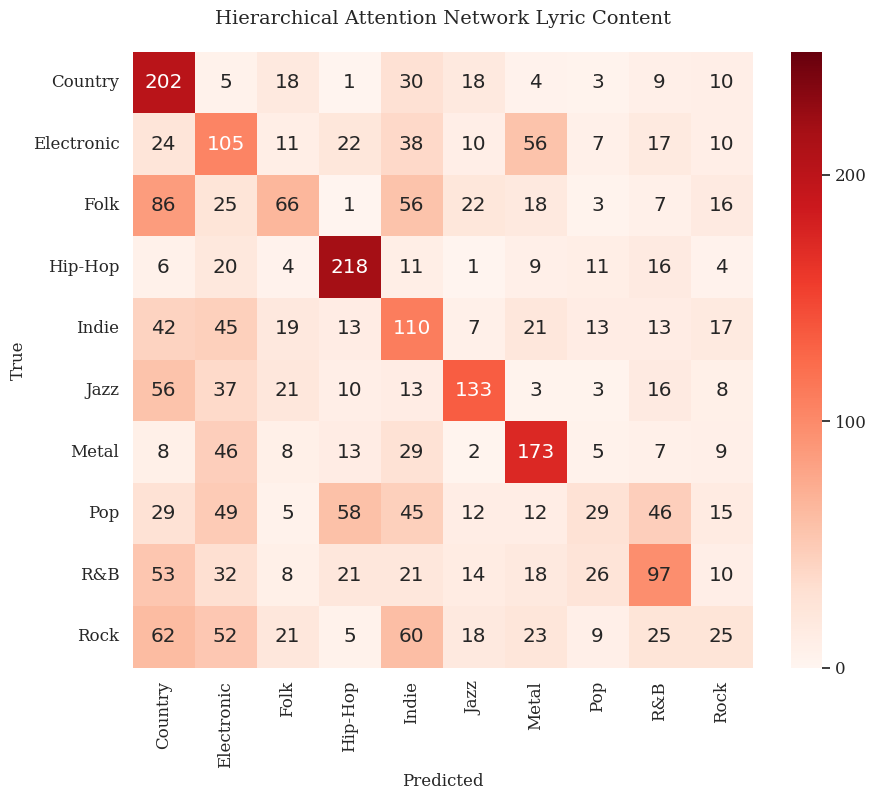

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Reds',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Hierarchical Attention Network Lyric Content', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/han_content_only.png', bbox_inches='tight')

In [ ]:
model_han.save('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_han_content')